In [1]:
USE_VAE = False

In [2]:
import numpy as np
from numpy import clip
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


MODEL_CHANNELS = 4 if USE_VAE else 3

In [3]:
GLOBAL_MEAN = np.load("data/global_mean.npy")/255
GLOBAL_STD = np.load("data/global_std.npy")/255

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

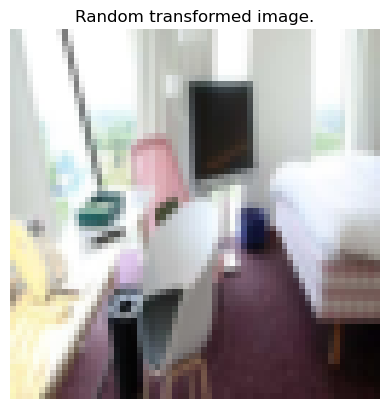

In [13]:
resize_size = 64

transform = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=GLOBAL_MEAN, std=GLOBAL_STD)
])

data_path = 'data/data0/lsun/bedroom'
batch_size = 32

image_dataset = ImageFolder(root=data_path, transform=transform)
image_dataset = Subset(image_dataset, torch.randperm(len(image_dataset))[:10000])
train_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

for idx, batch in enumerate(train_dataloader):
    break

plt.imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))
plt.title("Random transformed image.")
plt.axis('off')
plt.show()

In [14]:
from diffusers import AutoencoderKL

class VAE:
    vae_url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"

    def __init__(self, device):
        self.model = AutoencoderKL.from_single_file(self.vae_url).to(device)
        self.device = device

    def pil_to_latent(self, input):
        with torch.no_grad():
            latent = self.model.encode(input.to(self.device))
        return latent.latent_dist.sample()

    def latent_to_pil(self, encoded):
        with torch.no_grad():
            output_img = self.model.decode(encoded)
        return output_img.sample


vae = VAE(device)
# lat = vae.pil_to_latent(batch[0])
# decoded = vae.latent_to_pil(lat)

In [15]:
if USE_VAE:
    resize_size = 256

    transform = transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: vae.pil_to_latent(x.unsqueeze(0)).squeeze(0))
    ])

    data_path = 'data/data0/lsun/bedroom'
    batch_size = 32

    image_dataset = ImageFolder(root=data_path, transform=transform)
    image_dataset = Subset(image_dataset, torch.randperm(len(image_dataset))[:1000])
    train_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)
    
    for idx, batch in enumerate(train_dataloader):
        break

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, size):
        super(Block, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.dense_time = nn.Linear(out_channels, out_channels)
        self.norm = nn.LayerNorm([out_channels, size, size])

    def forward(self, x, t):
        x_parameter = F.relu(self.conv1(x))
        time_parameter = F.relu(self.dense_time(t))
        time_parameter = t.view(-1, self.out_channels, 1, 1)
        x_parameter = x_parameter * time_parameter
        x_out = F.relu(self.conv2(x) + x_parameter)
        x_out = self.norm(x_out)
        return x_out

class UNet(nn.Module):
    def __init__(self, layers_size):
        super().__init__()

        self.layers_size = layers_size
        self.scaling_factor = 8 if USE_VAE else 1

        self.block_down_1 = Block(in_channels=MODEL_CHANNELS, out_channels=self.layers_size, size=resize_size//self.scaling_factor)
        self.block_down_2 = Block(in_channels=self.layers_size, out_channels=self.layers_size, size=resize_size//(2*self.scaling_factor))
        self.block_down_3 = Block(in_channels=self.layers_size, out_channels=self.layers_size, size=resize_size//(4*self.scaling_factor))

        self.block_up_1 = Block(in_channels=2*self.layers_size, out_channels=self.layers_size, size=resize_size//(4*self.scaling_factor))
        self.block_up_2 = Block(in_channels=2*self.layers_size, out_channels=self.layers_size, size=resize_size//(2*self.scaling_factor))
        self.block_up_3 = Block(in_channels=2*self.layers_size, out_channels=self.layers_size, size=resize_size//self.scaling_factor)

        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.mlp_t_initial = nn.Linear(1, self.layers_size)
        self.norm_t_initial = nn.LayerNorm([self.layers_size])

        self.conv_out = nn.Conv2d(self.layers_size, MODEL_CHANNELS, kernel_size=1, padding=0)
        self.conv_middle = nn.Conv2d(self.layers_size, self.layers_size, kernel_size=3, padding="same")

    def forward(self, x_img, x_ts):

        x_ts = self.mlp_t_initial(x_ts)
        x_ts = self.norm_t_initial(x_ts)
        x_ts = F.relu(x_ts)

        x1 = self.block_down_1(x_img, x_ts)
        x = self.maxpool1(x1)
        x2 = self.block_down_2(x, x_ts)
        x = self.maxpool2(x2)
        x3 = self.block_down_3(x, x_ts)

        x = self.conv_middle(x3)

        x = torch.cat((x, x3), dim=1)
        x = self.block_up_1(x, x_ts)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        
        x = torch.cat((x, x2), dim=1)
        x = self.block_up_2(x, x_ts)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        
        x = torch.cat((x, x1), dim=1)
        x = self.block_up_3(x, x_ts)

        x = self.conv_out(x)
        return x

model = UNet(layers_size=128).to(device)
# model.load_state_dict(torch.load("best_unet_1k"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [43]:
def min_max_array(array):
    array = array.numpy()
    min_vals = np.reshape(np.min(array, axis=(2, 3)), (array.shape[0], 3, 1, 1))
    max_vals = np.reshape(np.max(array, axis=(2, 3)), (array.shape[0], 3, 1, 1))

    return (array - min_vals) / (max_vals - min_vals)

In [44]:
def standard_scale_array(array):
    mean_vals = torch.mean(array, dim=(2, 3), keepdim=True).to(device)
    std_vals = torch.std(array, dim=(2, 3), keepdim=True).to(device)
    
    return (array - mean_vals) / std_vals

In [45]:
timesteps = 32
time_bar = 1 - torch.linspace(0, 1.0, timesteps + 1)

def forward_noise(x, t):
    a = time_bar[t].to(device)
    b = time_bar[t + 1].to(device)
    
    noise = torch.randn_like(x).to(device)
    a = a.view((-1, 1, 1, 1))
    b = b.view((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return standard_scale_array(img_a), standard_scale_array(img_b)
    
def generate_ts(num):
    return torch.randint(0, timesteps, size=(num,))

In [46]:
epochs = 1000
for i in range(epochs):
    cumulated_loss = 0
    for x_img, _ in tqdm(train_dataloader, f"Epoch: {i+1}"):
        optimizer.zero_grad()
        if not USE_VAE:
            x_img = x_img.to(device)
            
        x_ts = generate_ts(len(x_img))
        x_a, x_b = forward_noise(x_img, x_ts)

        x_ts = x_ts.view(-1, 1).float().to(device)
        x_a = x_a.float()
        x_b = x_b.float()

        y_p = model(x_a, x_ts)
        # loss = torch.mean(torch.abs(y_p - x_b))
        loss = loss_func(y_p, x_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        cumulated_loss += loss.item() * x_img.shape[0]
    
    cumulated_loss /= len(train_dataloader.dataset)
    print(f"Epoch {i+1} loss: {cumulated_loss}.")

Epoch: 1: 100%|██████████| 313/313 [01:29<00:00,  3.51it/s]


Epoch 1 loss: 0.029143381213024257.


Epoch: 2: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch 2 loss: 0.003026138420403004.


Epoch: 3: 100%|██████████| 313/313 [01:34<00:00,  3.32it/s]


Epoch 3 loss: 0.0024311551585793497.


Epoch: 4: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch 4 loss: 0.0021568122684955597.


Epoch: 5:   1%|          | 2/313 [00:00<02:18,  2.24it/s]


KeyboardInterrupt: 

Predicting...: 32it [00:02, 11.45it/s]


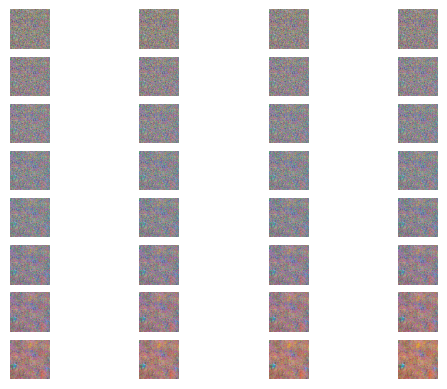

In [47]:
first_batch_size = resize_size if not USE_VAE else resize_size//8

x = torch.randn(batch_size, MODEL_CHANNELS, first_batch_size, first_batch_size).to(device)

x_subplot_shape = 4
y_subplot_shape = 8

fig_l, axes_l = plt.subplots(ncols=x_subplot_shape, nrows=y_subplot_shape, sharex=True, sharey=True)
with torch.no_grad():
    for ind, i in tqdm(enumerate(range(timesteps)), "Predicting..."):
        t = i
        x = model(x, torch.full([batch_size, 1], t, dtype=torch.float, device=device))
        x = standard_scale_array(x)
        if USE_VAE:
            x_for_img = min_max_array(vae.latent_to_pil(x[0].unsqueeze(0)).detach().cpu()).squeeze(0)
        else:
            x_for_img = min_max_array(x[0].unsqueeze(0).detach().cpu())[0]
        axes_l[(ind)//x_subplot_shape, (ind)%x_subplot_shape].imshow(np.transpose(x_for_img, (1, 2, 0)))
        axes_l[(ind)//x_subplot_shape, (ind)%x_subplot_shape].axis("off")
plt.show()

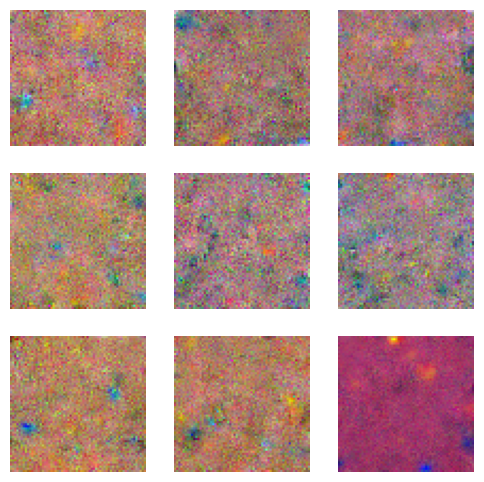

In [48]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))

for ind in range(9):
    if USE_VAE:
        array = vae.latent_to_pil(x[ind].unsqueeze(0)).detach().cpu().numpy()[0]
    else:
        array = x[ind].detach().cpu().numpy()
    #min max scaling
    min_vals = np.reshape(np.min(array, axis=(1, 2)), (3, 1, 1))
    max_vals = np.reshape(np.max(array, axis=(1, 2)), (3, 1, 1))
    scaled_array = (array - min_vals) / (max_vals - min_vals)

    if ind == 0:
        scaled_sample = np.expand_dims(np.copy(scaled_array), 0)
    else:
        scaled_sample = np.concatenate((scaled_sample, np.expand_dims(scaled_array, 0)), 0)

    axes[(ind)//3, (ind)%3].imshow(np.transpose(scaled_array, (1, 2, 0)))
    axes[(ind)//3, (ind)%3].axis('off')

In [53]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid_list = []
for i in tqdm(range(10), "Calculating avg FID..."):
    for idx, test_batch in enumerate(train_dataloader):
        break

    fid = FrechetInceptionDistance(feature=64)
    fid.update((test_batch[0][:9]*255).to(torch.uint8), real=True)
    fid.update((torch.from_numpy(scaled_sample)*255).to(torch.uint8), real=False)
    fid_list.append(fid.compute().item())

Calculating avg FID...: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [54]:
print(f"Averaged FID score for 10 random true image batches and generated sample is {np.average(fid_list)}.")

Averaged FID score for 10 random true image batches and generated sample is 56.20460090637207.
